In [1]:
# Change this depending on where notebook is running
import os
os.chdir('..')

data_loc = "data/"

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

import data
from model import *

Using TensorFlow backend.


In [3]:
# Define data locations
train_images = data_loc + "train_images/*"
test_images = data_loc + "test_images/*"

breed_labels_file = data_loc + "breed_labels.csv"
state_labels_file = data_loc + "state_labels.csv"
color_labels_file = data_loc + "color_labels.csv"

train_file = data_loc + "train/train.csv"
test_file = data_loc + "test/test.csv"

train_sentiment_location = data_loc + "train_sentiment"
test_sentiment_location = data_loc + "test_sentiment"

In [4]:
breed_labels = pd.read_csv(breed_labels_file)
state_labels = pd.read_csv(state_labels_file)
color_labels = pd.read_csv(color_labels_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [5]:
breed_cols = ['PetID','Type','Breed1', 'Breed2']

breeds_train_df = train_df[breed_cols]
breeds_test_df = test_df[breed_cols]

In [6]:
type1_breeds_train_df = breeds_train_df[breeds_train_df['Type'] == 1] # dogs
type2_breeds_train_df = breeds_train_df[breeds_train_df['Type'] == 2] # cats


In [7]:
print(type1_breeds_train_df.shape)
print(type2_breeds_train_df.shape)

(8132, 4)
(6861, 4)


In [8]:
breed_labels

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita
5,6,1,Alaskan Malamute
6,7,1,American Bulldog
7,8,1,American Eskimo Dog
8,9,1,American Hairless Terrier
9,10,1,American Staffordshire Terrier


In [9]:
type1_breed_labels = breed_labels[breed_labels['Type']==1]
type2_breed_labels = breed_labels[breed_labels['Type']==2]
print(type1_breed_labels.shape)
print(type2_breed_labels.shape)

(241, 3)
(66, 3)


In [10]:
# Run One hot encoding on the Breeds
type1_breed1_onehot = data.one_hot_encode(type1_breeds_train_df, 'Breed1', len(type1_breed_labels),
               type1_breed_labels['BreedID'])
type1_breed2_onehot = data.one_hot_encode(type1_breeds_train_df, 'Breed2', len(type1_breed_labels),
               type1_breed_labels['BreedID'])

type2_breed1_onehot = data.one_hot_encode(type2_breeds_train_df, 'Breed1', len(type2_breed_labels),
               type2_breed_labels['BreedID'])
type2_breed2_onehot = data.one_hot_encode(type2_breeds_train_df, 'Breed2', len(type2_breed_labels),
               type2_breed_labels['BreedID'])

In [11]:
# Weights for combining the one hot encodings
w_breed1 = 1
w_breed2 = 1

In [12]:
type1_breeds_onehot = w_breed1*type1_breed1_onehot + w_breed2*type1_breed2_onehot

type2_breeds_onehot = w_breed1*type2_breed1_onehot + w_breed2*type2_breed2_onehot

In [13]:
type2_breeds_onehot.shape

(6861, 66)

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(10)
type1_breeds_pca = pca.fit_transform(type1_breeds_onehot)
type2_breeds_pca = pca.fit_transform(type2_breeds_onehot)

In [16]:
print(type1_breeds_pca.shape)
print(type2_breeds_pca.shape)

(8132, 10)
(6861, 10)


In [17]:
y_type1 = train_df[train_df['Type']==1]
y_type2 = train_df[train_df['Type']==2]


type1_y_onehot = data.one_hot_encode(y_type1, 'AdoptionSpeed')
type2_y_onehot = data.one_hot_encode(y_type2, 'AdoptionSpeed')

In [18]:
# Combine Cats and Dogs Back together
breeds_pca = np.concatenate((type1_breeds_pca, type2_breeds_pca))
print(breeds_pca.shape)
y_onehot = np.concatenate((type1_y_onehot, type2_y_onehot))
print(y_onehot.shape)

(14993, 10)
(14993, 5)


In [19]:
# Create a mask for training and validation data
msk = np.random.rand(len(train_df)) < 0.8

train_x = breeds_pca[msk]
valid_x = breeds_pca[~msk]

train_y = y_onehot[msk]
valid_y = y_onehot[~msk]

In [20]:
class BreedModel(KaggleModel):
    def __init__(self, train, test, input_shape=10):
        kernel = Sequential(name='breeds_encoder')
        
        kernel.add(BatchNormalization(input_shape=(input_shape,)))
        
        kernel.add(Dense(128))
        kernel.add(Dense(128))
        
        kernel.add(Dense(64))
        kernel.add(Dense(64))

        kernel.add(Dense(32))
        kernel.add(Dense(32))
        
        
        kernel.add(Activation('relu'))
        
        # Use a single dense residual block
        """
        blk = Sequential()
        
        blk.add(Dropout(0.5, input_shape=kernel.output_shape[1:]))
        blk.add(Dense(128))
        blk.add(Activation('relu'))

        blk.add(Dense(128))
        blk.add(Activation('relu'))

        kernel.add(ResidualBlock(blk))
        """

        model = Sequential(name='breed')
        model.add(kernel)
        
        model.add(Dense(64, activation='relu'))

        # Labels are one of [0, 1, 2, 3, 4]
        model.add(Dense(5, activation='softmax'))

        # Build using the built model
        super().__init__(model, train, test)
    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
breeds_model = BreedModel((train_x, train_y),
                                 (valid_x, valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                33512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 35,949
Trainable params: 35,929
Non-trainable params: 20
_________________________________________________________________


In [22]:
breeds_model.compile()

In [23]:
breeds_model.train(epochs=50)

Train on 11938 samples, validate on 3055 samples
Epoch 1/50
11938/11938 [==============================] - 5s 440us/step - loss: 1.4812 - acc: 0.2930 - val_loss: 1.4705 - val_acc: 0.2799
Epoch 2/50
11938/11938 [==============================] - 2s 196us/step - loss: 1.4605 - acc: 0.3027 - val_loss: 1.4530 - val_acc: 0.2930
Epoch 3/50
11938/11938 [==============================] - 2s 199us/step - loss: 1.4571 - acc: 0.3037 - val_loss: 1.4596 - val_acc: 0.2714
Epoch 4/50
11938/11938 [==============================] - 2s 176us/step - loss: 1.4539 - acc: 0.3055 - val_loss: 1.4528 - val_acc: 0.2861
Epoch 5/50
11938/11938 [==============================] - 2s 151us/step - loss: 1.4536 - acc: 0.3093 - val_loss: 1.4525 - val_acc: 0.2884
Epoch 6/50
11938/11938 [==============================] - 2s 150us/step - loss: 1.4525 - acc: 0.3073 - val_loss: 1.4544 - val_acc: 0.2848
Epoch 7/50
11938/11938 [==============================] - 2s 149us/step - loss: 1.4499 - acc: 0.3090 - val_loss: 1.4515 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


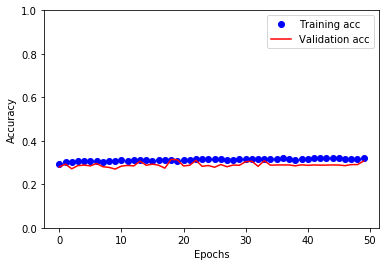

In [24]:
history = breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [25]:
# seperated train and valid
msk1 = np.random.rand(len(type1_breeds_pca)) < 0.8
msk2 = np.random.rand(len(type2_breeds_pca)) < 0.8


type1_train_x = type1_breeds_pca[msk1]
type1_valid_x = type1_breeds_pca[~msk1]

type1_train_y = type1_y_onehot[msk1]
type1_valid_y = type1_y_onehot[~msk1]

type2_train_x = type2_breeds_pca[msk2]
type2_valid_x = type2_breeds_pca[~msk2]

type2_train_y = type2_y_onehot[msk2]
type2_valid_y = type2_y_onehot[~msk2]

In [26]:
type1_breeds_model = BreedModel((type1_train_x, type1_train_y),
                                 (type1_valid_x, type1_valid_y))
type1_breeds_model.compile()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                33512     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 325       
Total params: 35,949
Trainable params: 35,929
Non-trainable params: 20
_________________________________________________________________


In [27]:
type1_breeds_model.train(epochs=50)

Train on 6533 samples, validate on 1599 samples
Epoch 1/50
6533/6533 [==============================] - 5s 728us/step - loss: 1.4657 - acc: 0.3078 - val_loss: 1.4430 - val_acc: 0.3152
Epoch 2/50
6533/6533 [==============================] - 2s 301us/step - loss: 1.4334 - acc: 0.3211 - val_loss: 1.4260 - val_acc: 0.3258
Epoch 3/50
6533/6533 [==============================] - 2s 295us/step - loss: 1.4281 - acc: 0.3242 - val_loss: 1.4295 - val_acc: 0.3215
Epoch 4/50
6533/6533 [==============================] - 2s 300us/step - loss: 1.4261 - acc: 0.3303 - val_loss: 1.4332 - val_acc: 0.3077
Epoch 5/50
6533/6533 [==============================] - 2s 309us/step - loss: 1.4273 - acc: 0.3196 - val_loss: 1.4258 - val_acc: 0.3215
Epoch 6/50
6533/6533 [==============================] - 3s 446us/step - loss: 1.4238 - acc: 0.3250 - val_loss: 1.4253 - val_acc: 0.3221
Epoch 7/50
6533/6533 [==============================] - 3s 407us/step - loss: 1.4215 - acc: 0.3303 - val_loss: 1.4327 - val_acc: 0.3139


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


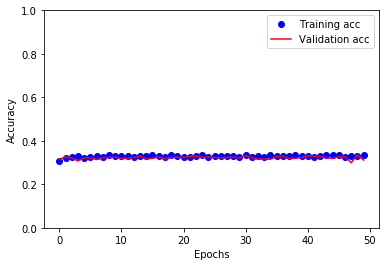

In [28]:
history = type1_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [29]:
type2_breeds_model = BreedModel((type2_train_x, type2_train_y),
                                 (type2_valid_x, type2_valid_y))
type2_breeds_model.compile()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
breeds_encoder (Sequential)  (None, 32)                33512     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 325       
Total params: 35,949
Trainable params: 35,929
Non-trainable params: 20
_________________________________________________________________


In [30]:
type2_breeds_model.train(epochs=50)

Train on 5448 samples, validate on 1413 samples
Epoch 1/50
5448/5448 [==============================] - 4s 799us/step - loss: 1.5126 - acc: 0.2695 - val_loss: 1.4920 - val_acc: 0.2838
Epoch 2/50
5448/5448 [==============================] - 1s 162us/step - loss: 1.4844 - acc: 0.2869 - val_loss: 1.4750 - val_acc: 0.2944
Epoch 3/50
5448/5448 [==============================] - 1s 272us/step - loss: 1.4807 - acc: 0.2827 - val_loss: 1.4942 - val_acc: 0.2803
Epoch 4/50
5448/5448 [==============================] - 1s 205us/step - loss: 1.4781 - acc: 0.2898 - val_loss: 1.4854 - val_acc: 0.2930
Epoch 5/50
5448/5448 [==============================] - 1s 171us/step - loss: 1.4760 - acc: 0.2871 - val_loss: 1.4902 - val_acc: 0.2880
Epoch 6/50
5448/5448 [==============================] - 1s 191us/step - loss: 1.4744 - acc: 0.2963 - val_loss: 1.4861 - val_acc: 0.2916
Epoch 7/50
5448/5448 [==============================] - 1s 273us/step - loss: 1.4758 - acc: 0.2882 - val_loss: 1.4828 - val_acc: 0.2979


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


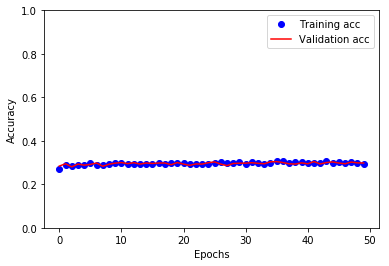

In [31]:
history = type2_breeds_model.model.history
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()